# Get packages, libraries and set variables

In [1]:
!pip install Lifetimes kaggle sweetviz

  Obtaining dependency information for Lifetimes from https://files.pythonhosted.org/packages/c5/1f/ee6a471dcb5cb2f4dbc219023e07991f3b917875f9c8a5f5d77c00ddabca/Lifetimes-0.11.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for sweetviz from https://files.pythonhosted.org/packages/89/50/8d3f7ca820267a38b42c64778db0f186d85cec6e3f0c5210eab9c16e783f/sweetviz-2.3.1-py3-none-any.whl.metadata
  Obtaining dependency information for importlib-resources>=1.2.0 from https://files.pythonhosted.org/packages/e1/6a/4604f9ae2fa62ef47b9de2fa5ad599589d28c9fd1d335f32759813dfa91e/importlib_resources-6.4.5-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 6.6 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 5.6 MB/s eta 0:00:00m eta 0:00:010:00:01
  Created wheel for kaggle: filename=kaggle-1.6.1

In [16]:
!unzip ecommerce-data.zip

Archive:  ecommerce-data.zip
  inflating: data.csv                


In [36]:
import warnings
from operator import attrgetter
from IPython.display import display, Markdown

import datetime as dt

import pandas as pd
import numpy as np
import sweetviz as sv

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix, plot_period_transactions, plot_history_alive, plot_cumulative_transactions
from lifetimes.utils import summary_data_from_transaction_data

%matplotlib inline

warnings.filterwarnings('ignore')

# Loading and Checking Data Quality

In [37]:
data_path = "data.csv"

df = pd.read_csv(data_path,
                 header = 0,
                 encoding = 'unicode_escape',
                 dtype = {'CustomerID': str,
                          'InvoiceID': str},
                 parse_dates = ['InvoiceDate'],
                 infer_datetime_format = True)
df.sample(3)

FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'

                                             |      | [  0%]   00:00 -> (? left)


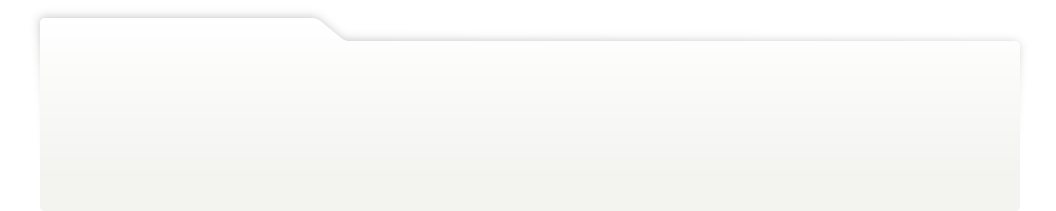
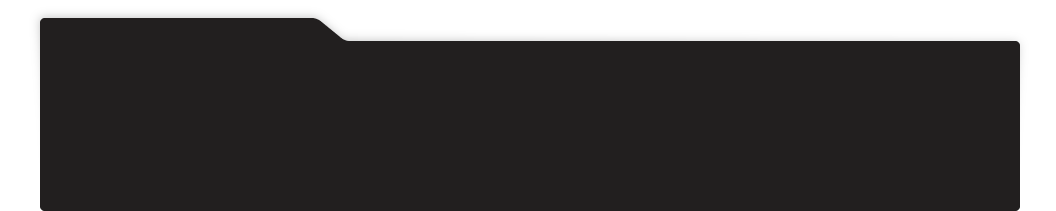
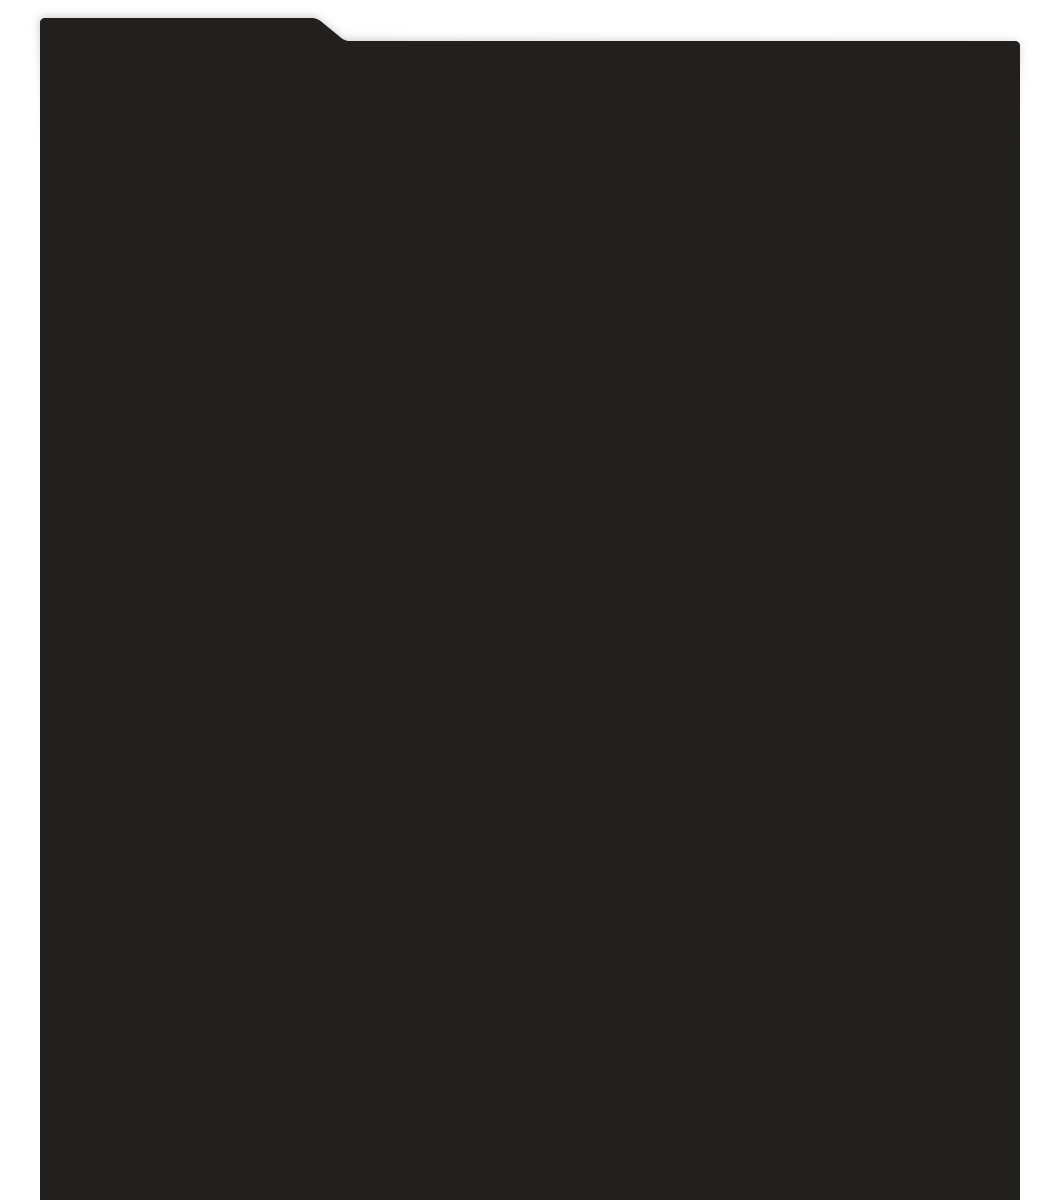
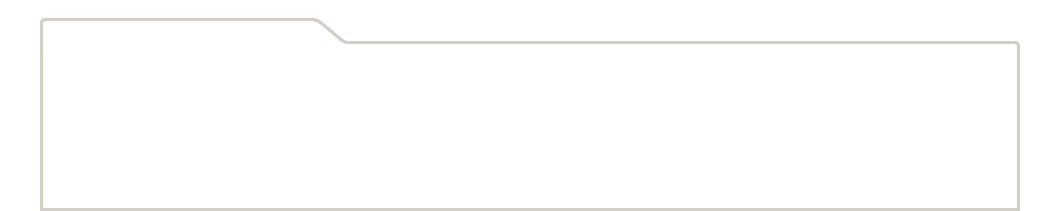
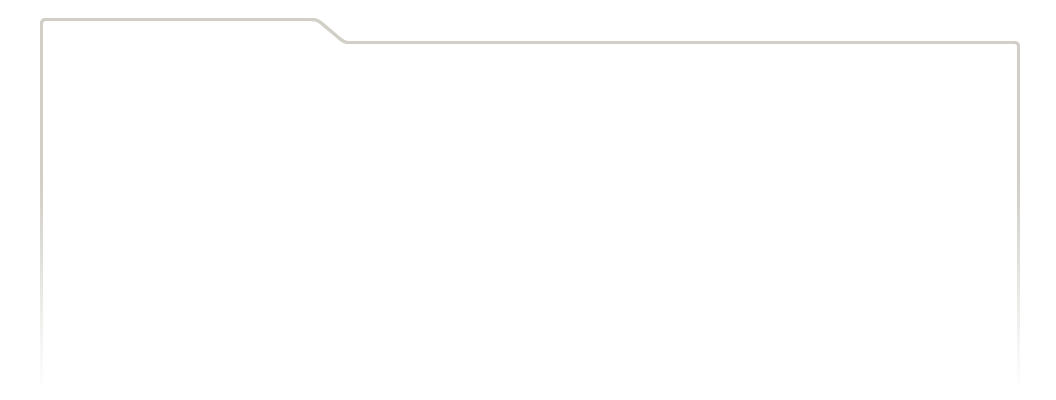
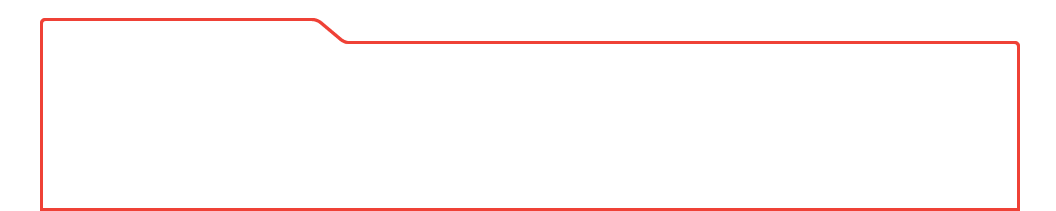
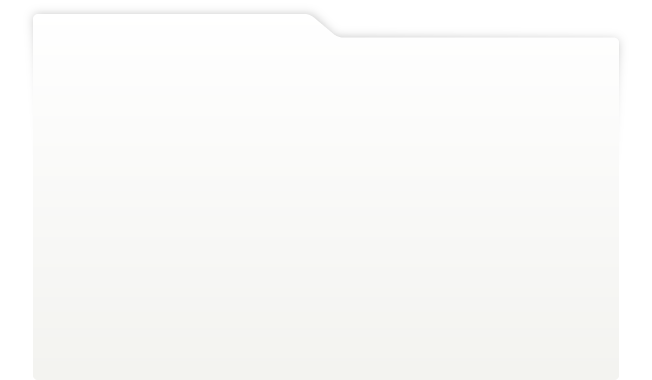
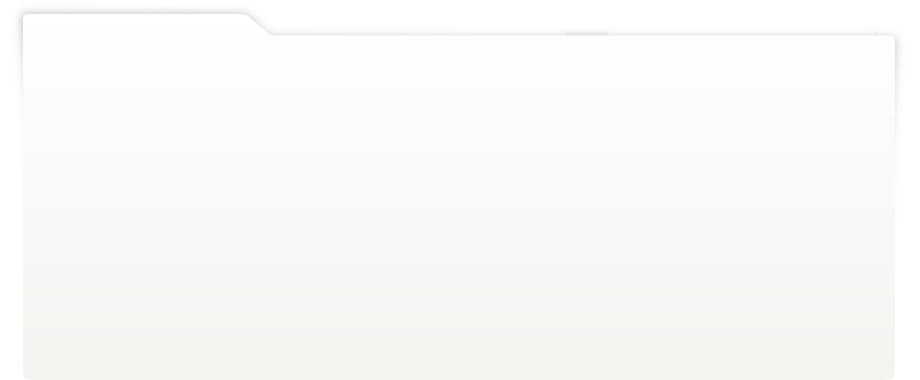
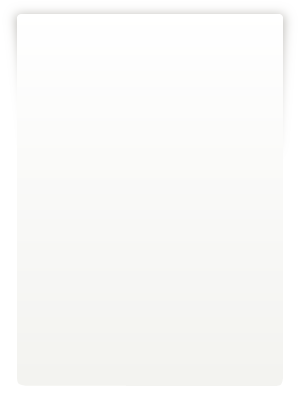
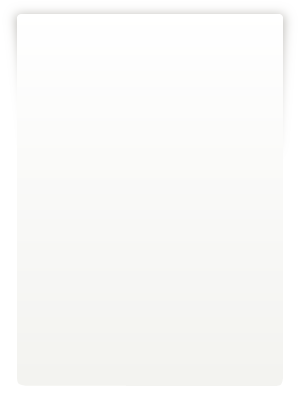
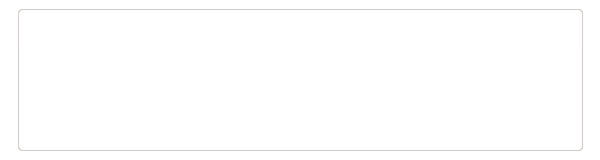
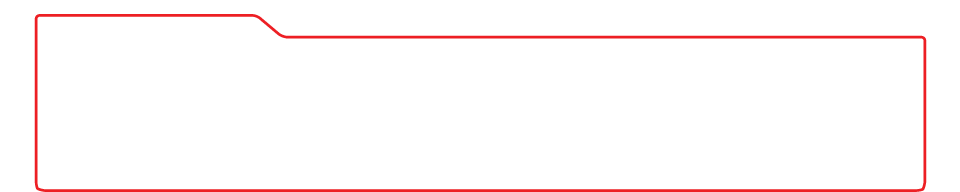
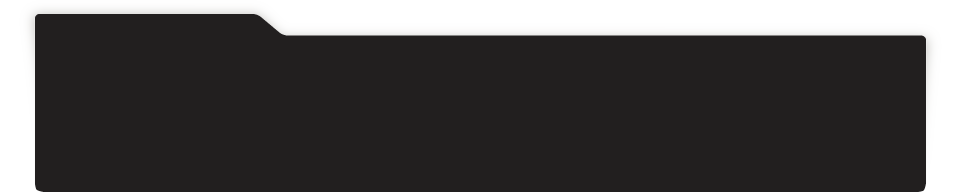
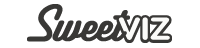
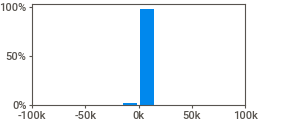
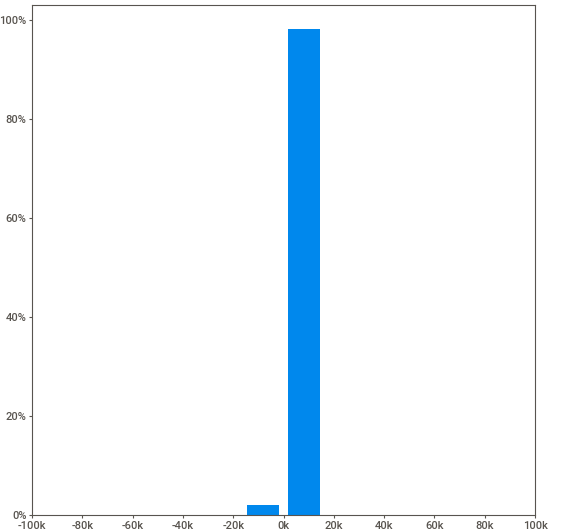
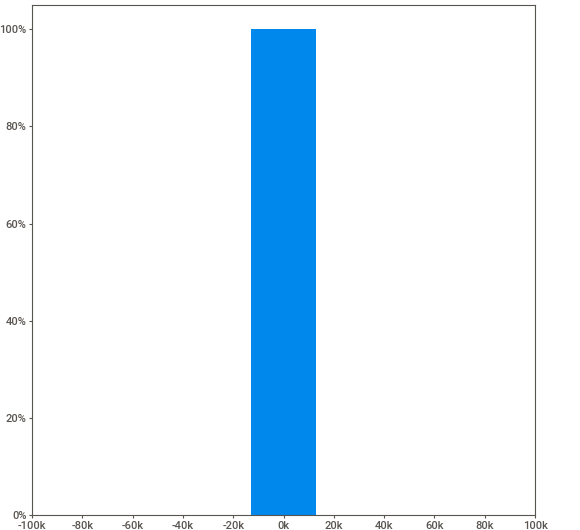
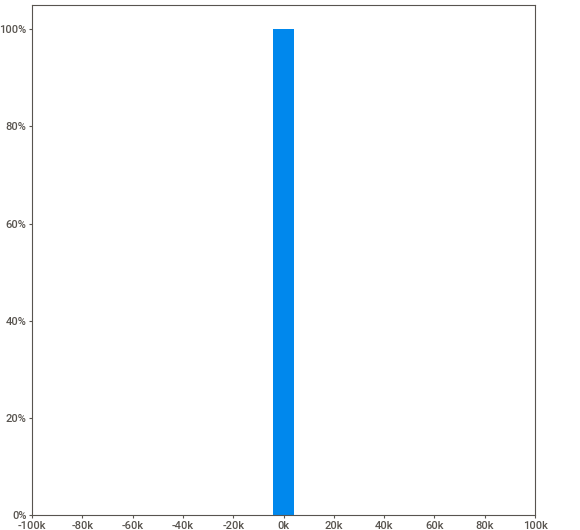
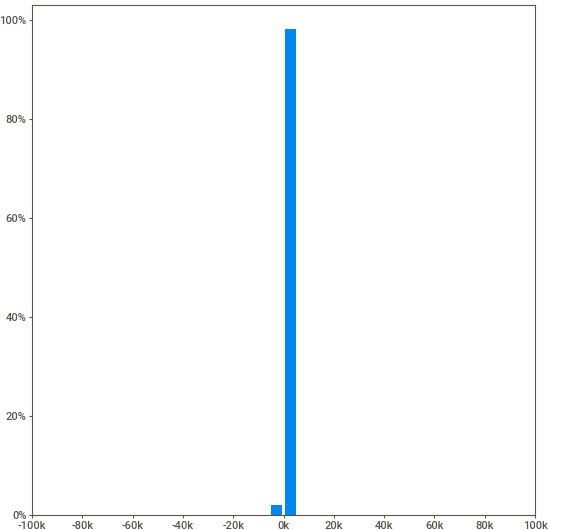
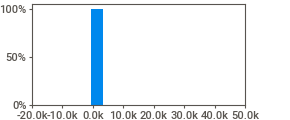
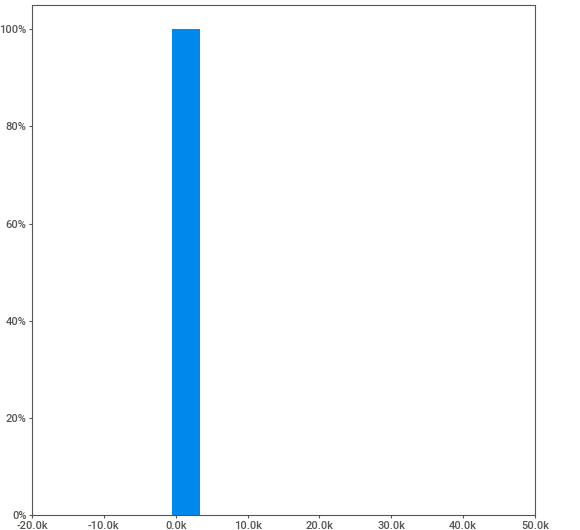
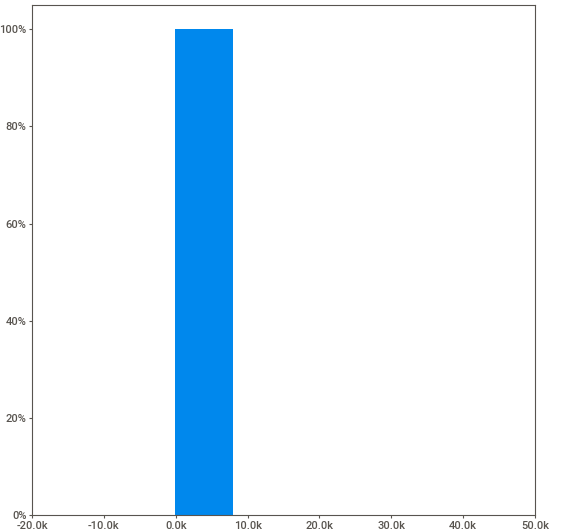
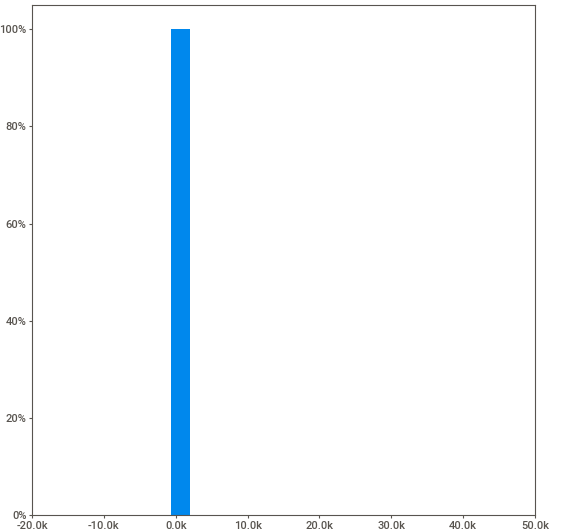
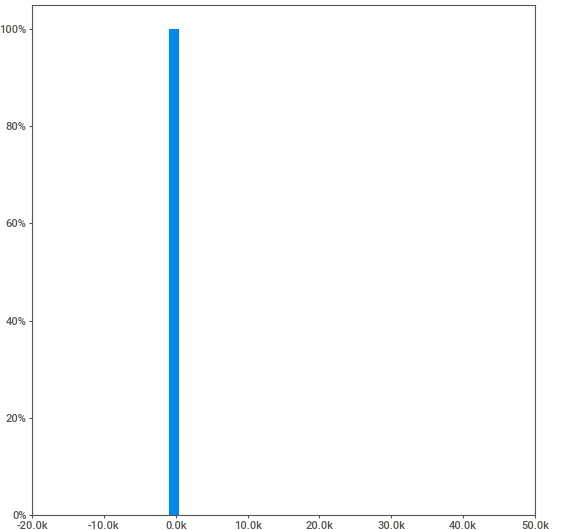
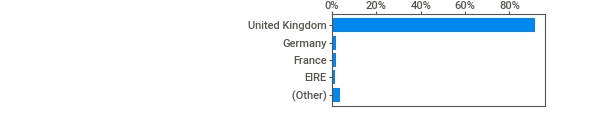
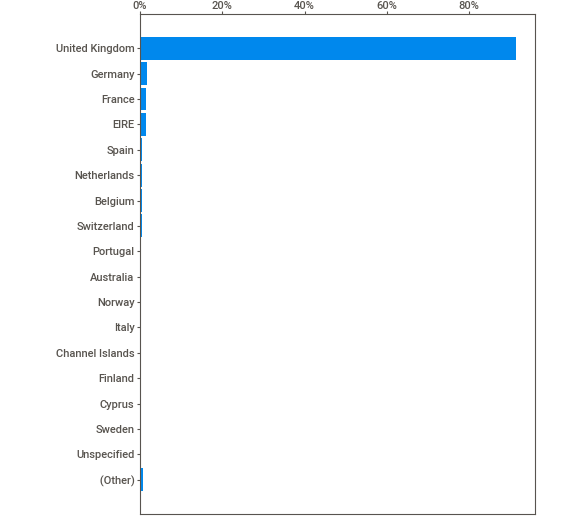
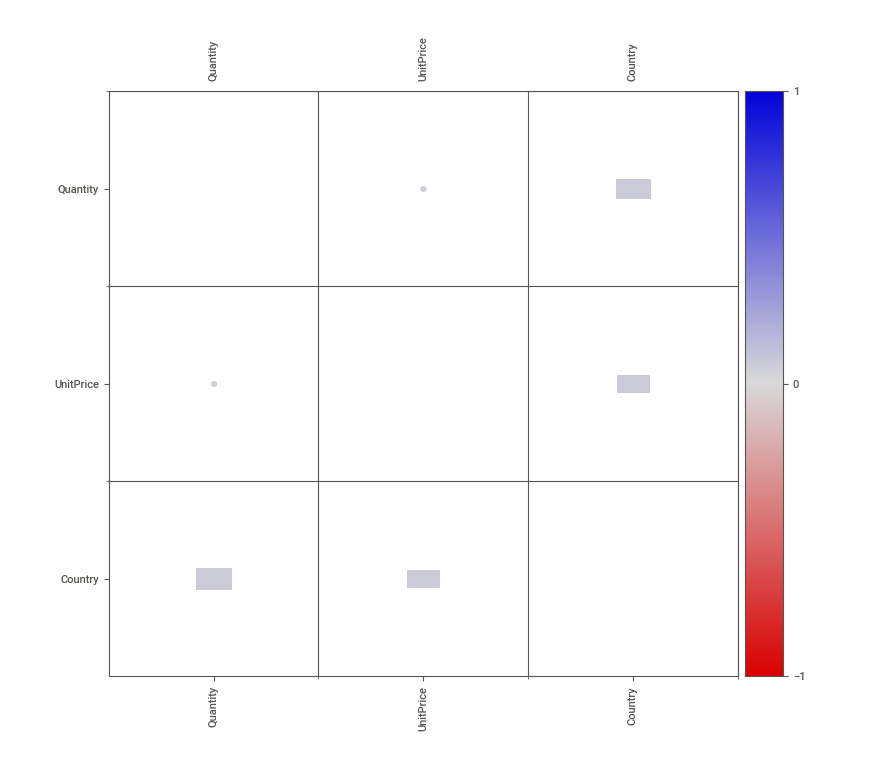
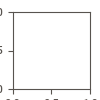

In [18]:
# create initial exploration reporting and show
report = sv.analyze(df)
report.show_notebook()

# Check Overall Descriptive Stats

In [19]:
# Display basic information about the dataframe
display(Markdown("### DataFrame Info:"))
display(df.info())

# Display the first few rows
display(Markdown("### First 5 Rows:"))
display(df.head())

### DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


None

### First 5 Rows:

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [20]:
# Describe the numerical columns
display(Markdown("### Summary Statistics for Numerical Columns:"))
display(df[['Quantity', 'UnitPrice']].describe())

# Check for missing values
display(Markdown("### Missing Values per Column:"))
display(df.isnull().sum().to_frame('Missing Values').reset_index().rename(columns={'index': 'Column'}))

# Check for unique values in key columns
display(Markdown("### Unique Values in Key Columns:"))
unique_counts = {
    'StockCode': df['StockCode'].nunique(),
    'Description': df['Description'].nunique(),
    'CustomerID': df['CustomerID'].nunique()
}
display(pd.DataFrame(list(unique_counts.items()), columns=['Column', 'Unique Count']))

# Check for duplicate rows
display(Markdown("### Number of Duplicate Rows:"))
display(pd.DataFrame({'Duplicate Rows': [df.duplicated().sum()]}))

### Summary Statistics for Numerical Columns:

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


### Missing Values per Column:

,Column,Missing Values
0,InvoiceNo,0
1,StockCode,0
2,Description,1454
3,Quantity,0
4,InvoiceDate,0
5,UnitPrice,0
6,CustomerID,135080
7,Country,0


### Unique Values in Key Columns:

,Column,Unique Count
0,StockCode,4070
1,Description,4223
2,CustomerID,4372


### Number of Duplicate Rows:

,Duplicate Rows
0,5268


## Cut out outliers, create RFM scores and segments

### preprocess

In [21]:
def preprocess_data(df):
    """
    Preprocesses the e-commerce data for RFM analysis.
    """
    # Create a copy to avoid modifying original data
    df = df.copy()

    # Remove duplicates
    df = df.drop_duplicates()

    # Filter out returns (negative quantities) and cancelled orders
    df = df[
        (df['Quantity'] > 0) &
        (df['UnitPrice'] > 0) &
        (~df['InvoiceNo'].astype(str).str.contains('C', case=False))
    ]

    # Calculate total price per row
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

    # Aggregate data to the invoice level
    invoice_df = df.groupby(['CustomerID', 'InvoiceNo']).agg({
        'InvoiceDate': 'max',
        'TotalPrice': 'sum'
    }).reset_index()

    return invoice_df

### Create and assign segments

In [22]:
def score_feature(series, bins=5, reverse=False):
    """
    Score a feature on a 1-5 scale, handling duplicate values.
    """
    labels = range(1, bins + 1) if not reverse else range(bins, 0, -1)

    # Handle series with too many duplicate values
    if series.nunique() < bins:
        # Use rank method for very few unique values
        ranks = series.rank(method='dense')
        scores = pd.Series(index=series.index)
        max_rank = ranks.max()

        for i, label in enumerate(labels, 1):
            mask = (ranks > (i-1) * max_rank/bins) & (ranks <= i * max_rank/bins)
            scores[mask] = label
        return scores.astype(int)

    # For series with enough unique values, use percentile-based scoring
    try:
        percentiles = np.linspace(0, 100, bins + 1)
        bins = np.percentile(series, percentiles)
        # Remove duplicate bin edges
        bins = np.unique(bins)
        # Adjust labels if necessary
        adjusted_labels = range(1, len(bins)) if not reverse else range(len(bins)-1, 0, -1)
        scores = pd.cut(series, bins=bins, labels=adjusted_labels, include_lowest=True)
        return scores.astype(int)
    except:
        # Fallback method using rank
        ranks = series.rank(pct=True)
        scores = pd.qcut(ranks, q=bins, labels=labels, duplicates='drop')
        return scores.astype(int)

def calculate_rfm(invoice_df, analysis_date=None):
    """
    Calculates RFM metrics and segments customers.
    """
    if analysis_date is None:
        analysis_date = invoice_df['InvoiceDate'].max()

    # Calculate RFM metrics
    rfm = summary_data_from_transaction_data(
        invoice_df,
        customer_id_col='CustomerID',
        datetime_col='InvoiceDate',
        monetary_value_col='TotalPrice',
        observation_period_end=analysis_date
    )

    # Convert frequency to integer
    rfm['frequency'] = rfm['frequency'].astype(int)

    # Calculate RFM scores
    rfm['R'] = score_feature(rfm['recency'], reverse=True)
    rfm['F'] = score_feature(rfm['frequency'])
    rfm['M'] = score_feature(rfm['monetary_value'])

    # # Calculate RFM Score
    # rfm['RFM_Score'] = rfm.apply(lambda x: f"{x['R']}{x['F']}{x['M']}", axis=1)

    # Define customer segments
    def segment_customer(row):
        r, f, m = row['R'], row['F'], row['M']

        if r >= 4 and f >= 4 and m >= 4:
            return 'Champions'
        elif r >= 4 and f >= 3:
            return 'Loyal Customers'
        elif r >= 3 and f >= 3 and m >= 3:
            return 'Potential Loyalists'
        elif r >= 4 and f <= 2:
            return 'New Customers'
        elif r <= 2 and f >= 4 and m >= 4:
            return 'At Risk Customers'
        elif r <= 2 and f >= 3:
            return 'Need Attention'
        elif r <= 2 and f <= 2 and m <= 2:
            return 'Lost Customers'
        elif r >= 3 and f <= 2 and m <= 2:
            return 'Lost Cheap Customers'
        else:
            return 'Average Customers'

    # Apply segmentation
    rfm['Customer_Segment'] = rfm.apply(segment_customer, axis=1)

    return rfm

In [23]:
def analyze_segments(rfm):
    """
    Provides summary statistics for each customer segment.
    """
    # Calculate basic statistics
    segment_stats = rfm.groupby('Customer_Segment').agg({
        'recency': ['count', 'mean'],
        'frequency': 'mean',
        'monetary_value': ['mean', 'sum']
    }).round(2)

    # Rename columns for clarity
    segment_stats.columns = [
        'Count', 'Avg Recency (days)',
        'Avg Frequency',
        'Avg Monetary Value', 'Total Revenue'
    ]

    # Add percentage of customers in each segment
    total_customers = len(rfm)
    segment_stats['Percentage'] = (segment_stats['Count'] / total_customers * 100).round(2)

    return segment_stats

In [24]:
# Process the data
invoice_df = preprocess_data(df)
rfm_results = calculate_rfm(invoice_df)

# View segment distribution
print("\nCustomer Segments Distribution:")
print(rfm_results['Customer_Segment'].value_counts(normalize=True).round(3) * 100)


Customer Segments Distribution:
Customer_Segment
New Customers           39.9
Need Attention          21.3
Average Customers       17.5
Lost Cheap Customers     7.1
At Risk Customers        6.8
Lost Customers           4.8
Potential Loyalists      2.6
Loyal Customers          0.1
Name: proportion, dtype: float64


In [25]:
# View detailed analysis
segment_analysis = analyze_segments(rfm_results)
display(Markdown("### Segment Analysis:"))
display(segment_analysis)


### Segment Analysis:

,Count,Avg Recency (days),Avg Frequency,Avg Monetary Value,Total Revenue,Percentage
Customer_Segment,,,,,,
At Risk Customers,293,317.68,12.11,904.30,264960.76,6.75
Average Customers,759,156.33,1.72,728.65,553046.57,17.50
Lost Cheap Customers,310,87.54,1.31,142.59,44202.76,7.15
Lost Customers,208,245.05,1.46,158.23,32912.15,4.79
Loyal Customers,3,24.00,3.00,173.80,521.39,0.07
Need Attention,922,284.71,6.72,339.84,313328.57,21.25
New Customers,1732,1.69,0.12,36.66,63499.67,39.93
Potential Loyalists,111,107.49,4.11,497.03,55169.87,2.56


## Segment Analysis

### Plot segments

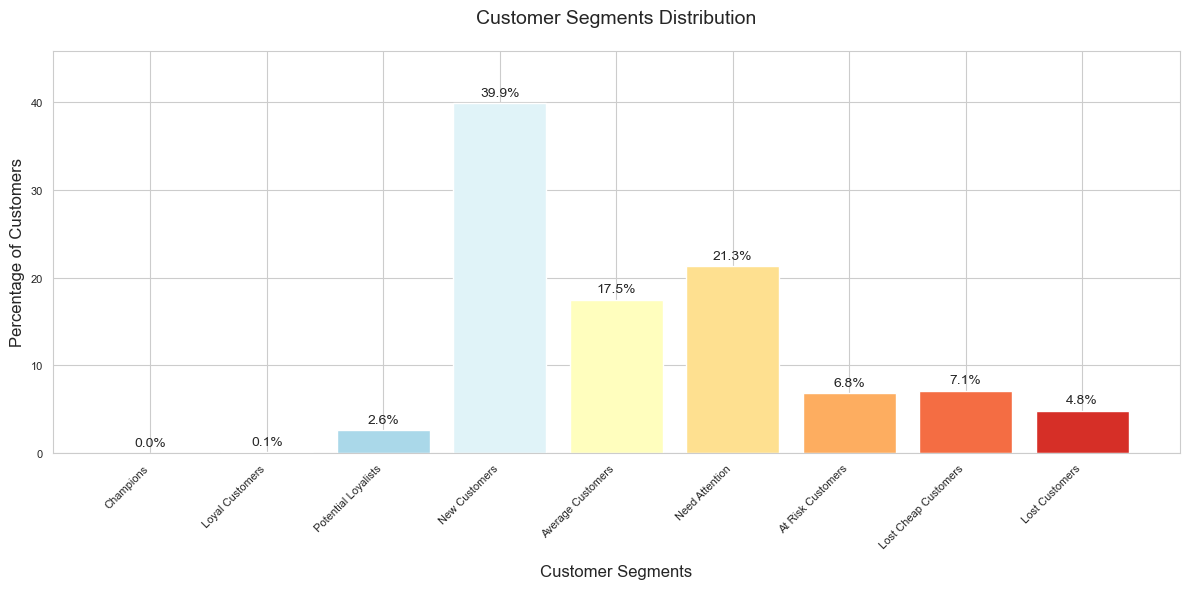

In [27]:
def plot_customer_segments(rfm, figsize=(12, 6)):
    """
    Creates a bar chart of customer segments ordered from best to worst,
    with percentage labels on top of each bar, including 0% segments.
    """
    # Define segment order from best to worst
    segment_order = [
        'Champions',
        'Loyal Customers',
        'Potential Loyalists',
        'New Customers',
        'Average Customers',
        'Need Attention',
        'At Risk Customers',
        'Lost Cheap Customers',
        'Lost Customers'
    ]

    # Calculate segment percentages
    segment_counts = rfm['Customer_Segment'].value_counts()
    segment_percentages = (segment_counts / len(rfm) * 100).round(1)

    # Create a complete series with all segments, filling missing ones with 0
    complete_percentages = pd.Series(0.0, index=segment_order)
    complete_percentages.update(segment_percentages)

    # Create figure and axis
    plt.figure(figsize=figsize)

    # Set style
    sns.set_style("whitegrid")

    # Create bar plot
    bars = plt.bar(
        range(len(segment_order)),
        complete_percentages,
        color=sns.color_palette("RdYlBu_r", n_colors=len(segment_order))
    )

    # Customize the plot
    plt.xticks(
        range(len(segment_order)),
        segment_order,
        rotation=45,
        ha='right'
    )

    # Add percentage labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 0.5,
            f'{height}%',
            ha='center',
            va='bottom'
        )

    # Customize labels and title
    plt.xlabel('Customer Segments', fontsize=12, labelpad=10)
    plt.ylabel('Percentage of Customers', fontsize=12)
    plt.title('Customer Segments Distribution', fontsize=14, pad=20)

    # Adjust y-axis to add some padding for labels
    plt.ylim(0, max(max(complete_percentages) * 1.15, 5))  # Minimum height of 5% for visibility

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    return plt.gcf()

fig = plot_customer_segments(rfm_results)
plt.show()

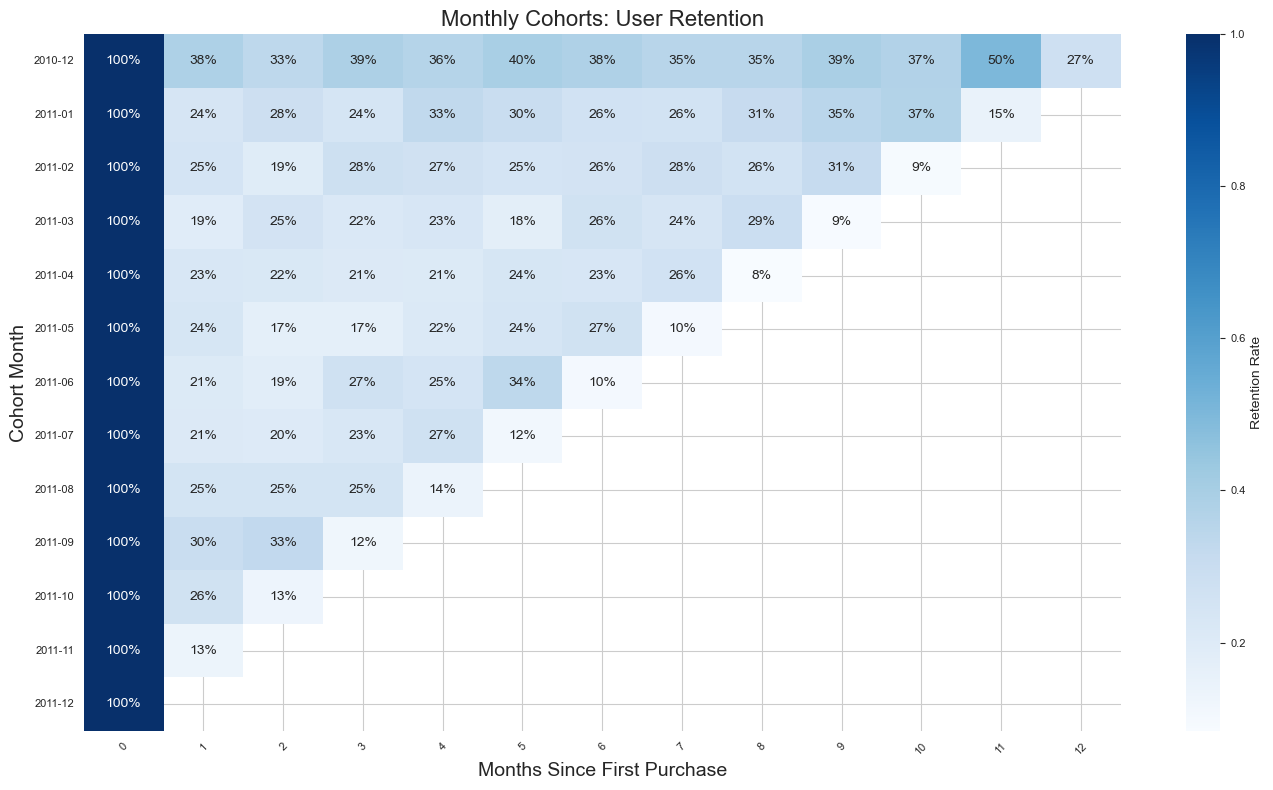

In [28]:
def cohorts(dataframe):

    # Prepare data by removing duplicates and extracting necessary columns
    data = dataframe[["CustomerID", "InvoiceNo", "InvoiceDate"]].drop_duplicates()

    # Create order month and cohort month columns
    data["order_month"] = data["InvoiceDate"].dt.to_period("M")
    data["cohort"] = data.groupby("CustomerID")["InvoiceDate"].transform("min").dt.to_period("M")

    # Aggregate data to get the number of unique customers for each cohort and order month
    cohort_data = data.groupby(["cohort", "order_month"]).agg(n_customers=("CustomerID", "nunique")).reset_index()

    # Calculate the period number (months since the cohort month)
    cohort_data["period_number"] = (cohort_data.order_month - cohort_data.cohort).apply(attrgetter("n"))

    # Pivot the data to create a retention matrix
    cohort_pivot = cohort_data.pivot_table(index="cohort", columns="period_number", values="n_customers")

    # Calculate cohort sizes and retention rates
    cohort_size = cohort_pivot.iloc[:, 0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

    # Plot the retention matrix using a heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(retention_matrix, annot=True, fmt=".0%", cmap="Blues", cbar_kws={'label': 'Retention Rate'}, mask=retention_matrix.isnull())
    plt.title("Monthly Cohorts: User Retention", fontsize=16)
    plt.xlabel("Months Since First Purchase", fontsize=14)
    plt.ylabel("Cohort Month", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Call the function with your dataframe
cohorts(df)

## Customer Lifetime Value

In [29]:
def calculate_ltv_on_rfm(rfm_df, time_period=1):
    """
    Calculate the Value (LTV) for each customer in the RFM dataframe.

    Parameters:
    - rfm_df (pd.DataFrame): The dataframe containing RFM metrics.
    - time_period (int): The time period for LTV prediction (e.g., months).

    Returns:
    - pd.DataFrame: The original dataframe with an added LTV column.
    """

    # Filter out customers with zero frequency or recency
    rfm_df = rfm_df[(rfm_df['frequency'] > 0) & (rfm_df['recency'] > 0)]

    # Fit the BG/NBD model
    bgf = BetaGeoFitter(penalizer_coef=0.01)
    bgf.fit(rfm_df['frequency'], rfm_df['recency'], rfm_df['T'])

    # Fit the Gamma-Gamma model
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(rfm_df['frequency'], rfm_df['monetary_value'])

    # Predict the expected number of transactions and monetary value
    rfm_df['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
        time_period, rfm_df['frequency'], rfm_df['recency'], rfm_df['T']
    )
    rfm_df['predicted_monetary_value'] = ggf.conditional_expected_average_profit(
        rfm_df['frequency'], rfm_df['monetary_value']
    )

    # Calculate the Lifetime Value (LTV)
    rfm_df['LTV'] = rfm_df['predicted_purchases'] * rfm_df['predicted_monetary_value']

    return rfm_df, bgf, ggf

# Calculate LTV and add it to the rfm_results dataframe
rfm_results_with_ltv, bgf, ggf = calculate_ltv_on_rfm(rfm_results)

# Display the updated dataframe
rfm_results_with_ltv.head()

,frequency,recency,T,monetary_value,R,F,M,Customer_Segment,predicted_purchases,predicted_monetary_value,LTV
CustomerID,,,,,,,,,,,
12347,6,365.0,367.0,599.701667,1,4,4,At Risk Customers,0.016614,618.557875,10.276884
12348,3,283.0,358.0,301.480000,1,3,3,Need Attention,0.010200,321.675137,3.281177
12352,6,260.0,296.0,368.256667,2,4,3,Need Attention,0.019644,380.077214,7.466376
12356,2,303.0,325.0,269.905000,1,2,3,Average Customers,0.008619,298.112247,2.569493
12358,1,149.0,150.0,683.200000,3,1,4,Average Customers,0.010336,834.574869,8.626260


posx and posy should be finite values
posx and posy should be finite values


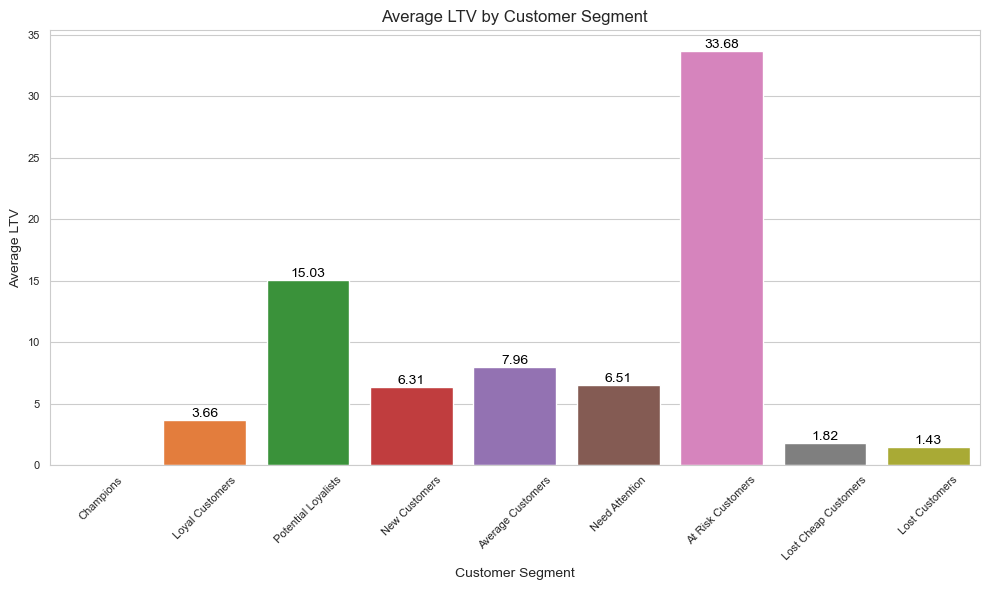

In [30]:
# Define the order of segments from most to least valuable
segment_order = [
    'Champions',
    'Loyal Customers',
    'Potential Loyalists',
    'New Customers',
    'Average Customers',
    'Need Attention',
    'At Risk Customers',
    'Lost Cheap Customers',
    'Lost Customers'
]

# Convert the Customer_Segment column to a categorical type with the specified order
rfm_results_with_ltv['Customer_Segment'] = pd.Categorical(
    rfm_results_with_ltv['Customer_Segment'],
    categories=segment_order,
    ordered=True
)

# Bar chart for average LTV by segment
plt.figure(figsize=(10, 6))
sns.barplot(x='Customer_Segment', y='LTV', data=rfm_results_with_ltv, estimator='mean', ci=None, order=segment_order)

# Add data labels to the bar chart
for index, bar in enumerate(plt.gca().patches):
    height = bar.get_height()
    plt.gca().text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate of the text
        height,  # Y-coordinate of the text
        f'{height:.2f}',  # Text to display
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10,  # Font size
        color='black'  # Text color
    )

plt.title('Average LTV by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Average LTV')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

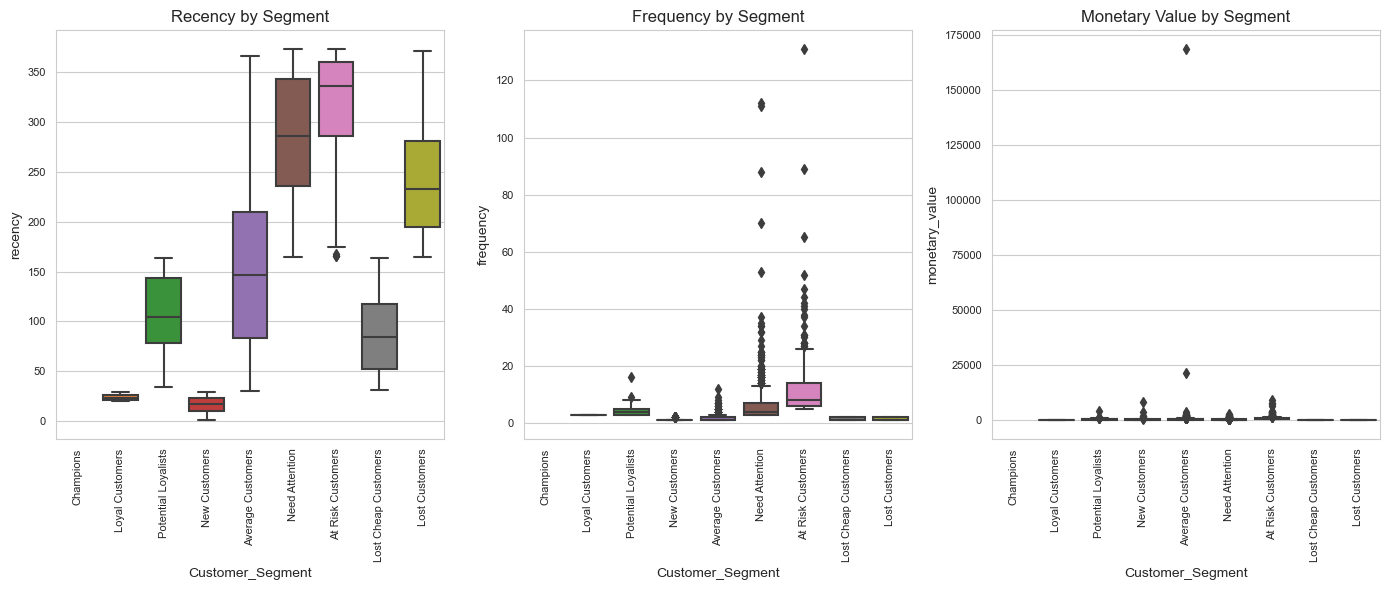

In [31]:
# Box plot for RFM metrics by segment with data labels for the median
plt.figure(figsize=(14, 6))

# Recency box plot with median labels
plt.subplot(1, 3, 1)
sns.boxplot(x='Customer_Segment', y='recency', data=rfm_results_with_ltv, order=segment_order)
plt.title('Recency by Segment')
plt.xticks(rotation=90)

# Frequency box plot with median labels
plt.subplot(1, 3, 2)
sns.boxplot(x='Customer_Segment', y='frequency', data=rfm_results_with_ltv, order=segment_order)
plt.title('Frequency by Segment')
plt.xticks(rotation=90)

# Monetary value box plot with median labels
plt.subplot(1, 3, 3)
sns.boxplot(x='Customer_Segment', y='monetary_value', data=rfm_results_with_ltv, order=segment_order)
plt.title('Monetary Value by Segment')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

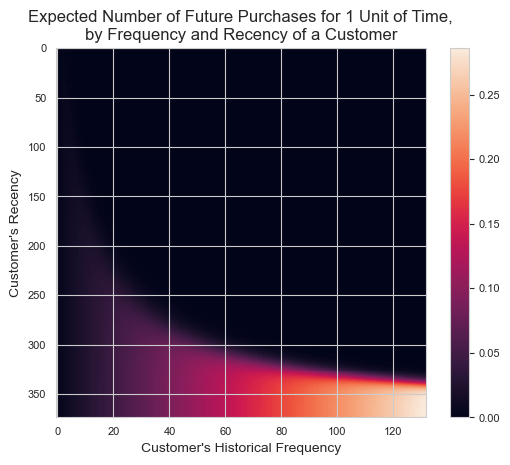

In [32]:
plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

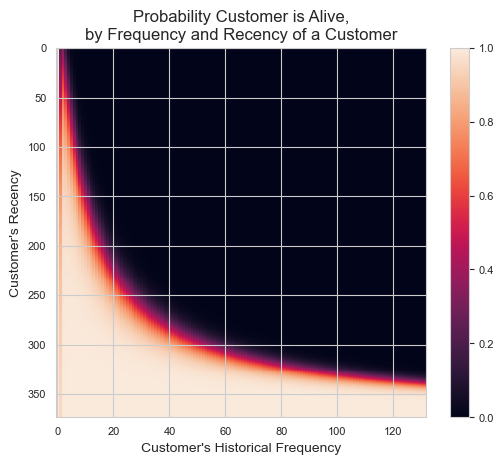

In [33]:
plot_probability_alive_matrix(bgf)

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

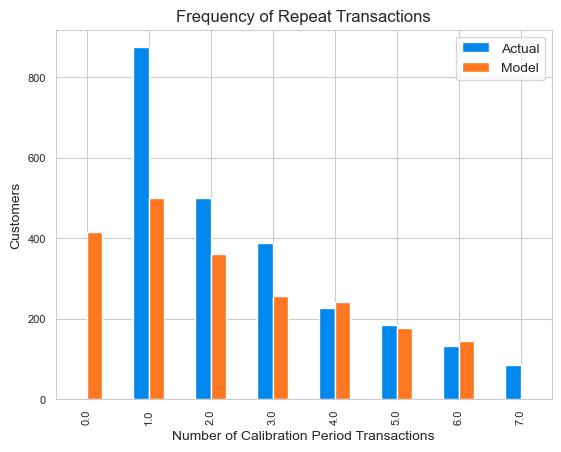

In [34]:
plot_period_transactions(bgf)